# 3. LogisticRegression

## Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rc('font', size=8)


## Добавим свою реализацию логистической регрессии

### Функция потерь логистической регресси

In [2]:
def log_loss(y, p):
    p = np.clip(p, 1e-15, 1 - 1e-15)  # 0 не должны попадать в np.log(p) и np.log(1.0 - p)
    return np.mean(- y * np.log(p) - (1.0 - y) * np.log(1.0 - p))


### Различные метрики для классификации

In [3]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)


def confusion_matrix(y_true, y_pred):
    positive = y_pred.astype(int) == 1
    negative = y_pred.astype(int) == 0

    tp = sum(y_true[positive] == y_pred[positive])
    fp = sum(y_true[positive] != y_pred[positive])
    tn = sum(y_true[negative] == y_pred[negative])
    fn = sum(y_true[negative] != y_pred[negative])

    return np.array([[tn, fn], [fp, tp]])


def precision(y_true, y_pred):
    (tn, fn), (fp, tp) = confusion_matrix(y_true, y_pred)
    if tp + fp == 0:
        return 1

    return tp / (tp + fp)


def recall(y_true, y_pred):
    (tn, fn), (fp, tp) = confusion_matrix(y_true, y_pred)
    if tp + fp == 0:
        return 1

    return tp / (tp + fn)


def f_score(y_true, y_pred, B=1):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return (1 + B) * (precision_ * recall_) / (B**2 * precision_ + recall_)


### Функции для регуляризации

In [4]:
# L1 regularization
def lasso(w, lambda_):
    return lambda_ * np.where(w != 0, w/abs(w), 0)


# L2 regularization
def ridge(w, lambda_):
    return 2 * lambda_ * w


### Стандартизация

In [5]:
class StandardScaler:

    def __init__(self) -> None:
        self._x_mean = None
        self._x_std = None

    def fit(self, X, y=None):
        X = np.array(X)
        self._x_mean = X.mean(axis=0)
        self._x_std = X.std(axis=0)

    def transform(self, X, y=None):
        if self._x_mean is None or self._x_std is None:
            raise RuntimeError(
                "StandardScaler is not fited (fit method was never called)!"
            )

        X = np.array(X)
        return (X - self._x_mean) / self._x_std

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)


### Логистическая регрессия

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class LogisticRegression:

    def __init__(self,
                 eta=1e-3,
                 max_iter=1000,
                 threshold=0.5,
                 class_weight=None,
                 random_state=None,
                 fit_intercept=True,
                 l1_ratio=None,
                 l2_ratio=None,
                 tol=None,  # Tolerance for stopping criteria
                 history_step=100):

        self._eta = eta
        self._max_iter = max_iter
        self._threshold = threshold

        self._w = class_weight
        self._seed = random_state
        self._fit_intercept = fit_intercept
        self._data_prepared = False

        self._l1_ratio = l1_ratio
        self._l2_ratio = l2_ratio

        self._prev_error = float("inf")
        self._tolerance = tol

        self._history_step = history_step
        self.clear_history()

    def fit(self, X, y):
        X, y = self._prepare_data(X, y)
        self._init_weights(X.shape[1])
        self._data_prepared = True

        for i in range(self._max_iter):
            self._save_history(X, y, i)
            self._gradient_step(X, y)
            if self._early_stop(X, y):
                break

        self._save_history(X, y)
        self._data_prepared = False
        return self.history

    def _gradient_step(self, X, y):
        n = len(y)
        p_pred = self.predict_proba(X)
        grad = (1 / n) * ((p_pred - y) @ X)
        penalty = self._l1_reg()
        penalty += self._l2_reg()
        self._w -= self._eta * grad + penalty

    def predict(self, X):
        return np.where(self.predict_proba(X) >= self._threshold, 1, 0)

    def predict_proba(self, X):
        return sigmoid(self._prepare_data(X) @ self._w)

    def set_threshold(self, threshold):
        self._threshold = threshold

    def _loss(self, X, y_true):
        p_pred = self.predict_proba(X)
        return log_loss(y_true, p_pred)

    def _score(self, X, y_true):
        y_pred = self.predict(X)
        return accuracy(y_true, y_pred)

    @property
    def history(self):
        return pd.DataFrame(self._history)

    @property
    def coef_(self):
        return self._w.copy()

    @property
    def coef_history(self):
        return self._coef_history.copy()

    def _prepare_data(self, X, y=None):
        X = np.array(X)
        if not self._data_prepared:
            if len(X.shape) != 2:
                raise ValueError("Wrong X shape (len(X.shape) != 2)!")

            if self._fit_intercept:
                intercept = np.ones((X.shape[0], 1))
                X = np.hstack((intercept, X))

        if y is None:
            return X

        y = np.array(y)
        return X, y

    def _init_weights(self, size):
        if self._w is None:
            np.random.seed(self._seed)
            self._w = np.random.rand(size)
            self.clear_history()

    def _l1_reg(self):
        if self._l1_ratio is None:
            return 0

        return lasso(self._w, lambda_=self._l1_ratio)

    def _l2_reg(self):
        if self._l2_ratio is None:
            return 0

        return ridge(self._w, lambda_=self._l2_ratio)

    def _early_stop(self, X, y):
        if self._tolerance is not None:
            loss = self._loss(X, y)
            if abs(loss - self._prev_error) < self._tolerance:
                return True

            self._prev_error = loss

        return False

    def clear_history(self):
        self._history = {"step": [], "loss": [], "score": []}
        self._coef_history = None

    def _save_history(self, X, y, iteration=None):
        if iteration is None or iteration % self._history_step == 0:
            self._history["step"].append(len(self._history["step"]))
            self._history["loss"].append(self._loss(X, y))
            self._history["score"].append(self._score(X, y))

            if self._coef_history is None:
                self._coef_history = self.coef_

            self._coef_history = np.vstack((self._coef_history, self.coef_))


### Функция для отображения истории обучения

In [7]:
def plot_history(history, label=""):
    plt.subplot(2, 1, 1)
    loss = history['loss'][len(history)-1]
    plt.plot(history["step"],
             history["loss"],
             alpha=0.7,
             label=f"{label} ({loss})")
    plt.ylabel("Loss")
    plt.xlabel("Step")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    score = history['score'][len(history)-1]
    plt.plot(history["step"],
             history["score"],
             alpha=0.7,
             label=f"{label} ({score})")
    plt.ylabel("Accuracy")
    plt.xlabel("Step")
    plt.legend()


## Посмотрим как гиперпараметры влияют на работу модели

### Данные для обучения

In [8]:
X = np.array([[1, 1, 2, 1, 3, 0, 5, 10, 1, 2],  # стаж репетитора
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],  # средняя стоимость занятия
              [21, 25, 27, 20, 25, 18, 35, 60, 20, 30]],  # возраст репетитора
             dtype=np.float64).T

y = np.array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0])  # подходит или нет репетитор
X

array([[1.00e+00, 5.00e+02, 2.10e+01],
       [1.00e+00, 7.00e+02, 2.50e+01],
       [2.00e+00, 7.50e+02, 2.70e+01],
       [1.00e+00, 6.00e+02, 2.00e+01],
       [3.00e+00, 1.45e+03, 2.50e+01],
       [0.00e+00, 8.00e+02, 1.80e+01],
       [5.00e+00, 1.50e+03, 3.50e+01],
       [1.00e+01, 2.00e+03, 6.00e+01],
       [1.00e+00, 4.50e+02, 2.00e+01],
       [2.00e+00, 1.00e+03, 3.00e+01]])

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.57142857, -0.97958969, -0.60595294],
       [-0.57142857, -0.56713087, -0.264571  ],
       [-0.21428571, -0.46401617, -0.09388003],
       [-0.57142857, -0.77336028, -0.69129842],
       [ 0.14285714,  0.97958969, -0.264571  ],
       [-0.92857143, -0.36090146, -0.86198939],
       [ 0.85714286,  1.08270439,  0.58888384],
       [ 2.64285714,  2.11385144,  2.72252095],
       [-0.57142857, -1.08270439, -0.69129842],
       [-0.21428571,  0.05155735,  0.16215642]])

### Влияние скорости обучения

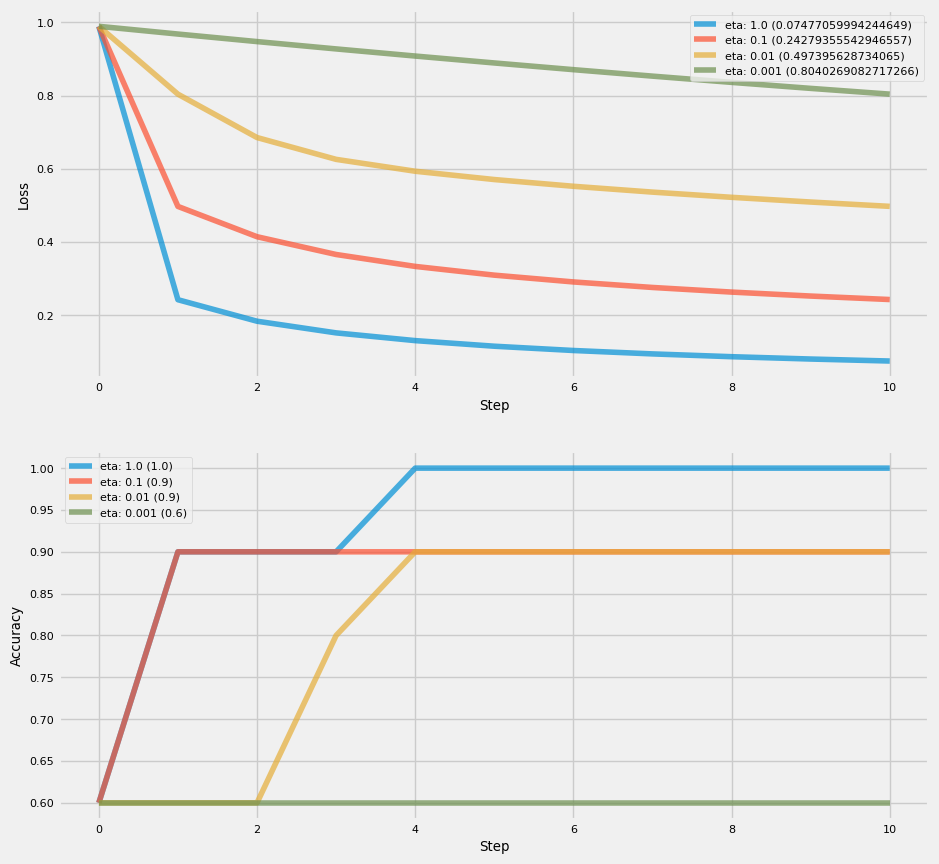

In [10]:
eta = 1e-2
max_iter = 1000
random_state = 64

plt.figure(figsize=(10, 10))
for eta in [1.0, 1e-1, 1e-2, 1e-3]:
    lr = LogisticRegression(eta=eta, max_iter=max_iter, random_state=random_state)
    hist = lr.fit(X, y)
    plot_history(hist, label=f"eta: {eta}")

plt.show()

Тут всё также как и у линейной регрессии.
Увеличение скорости обучения ускоряет обучение модели, но есть риск перескочить минимум при слишком больших значениях.

### Влияние количества итераций

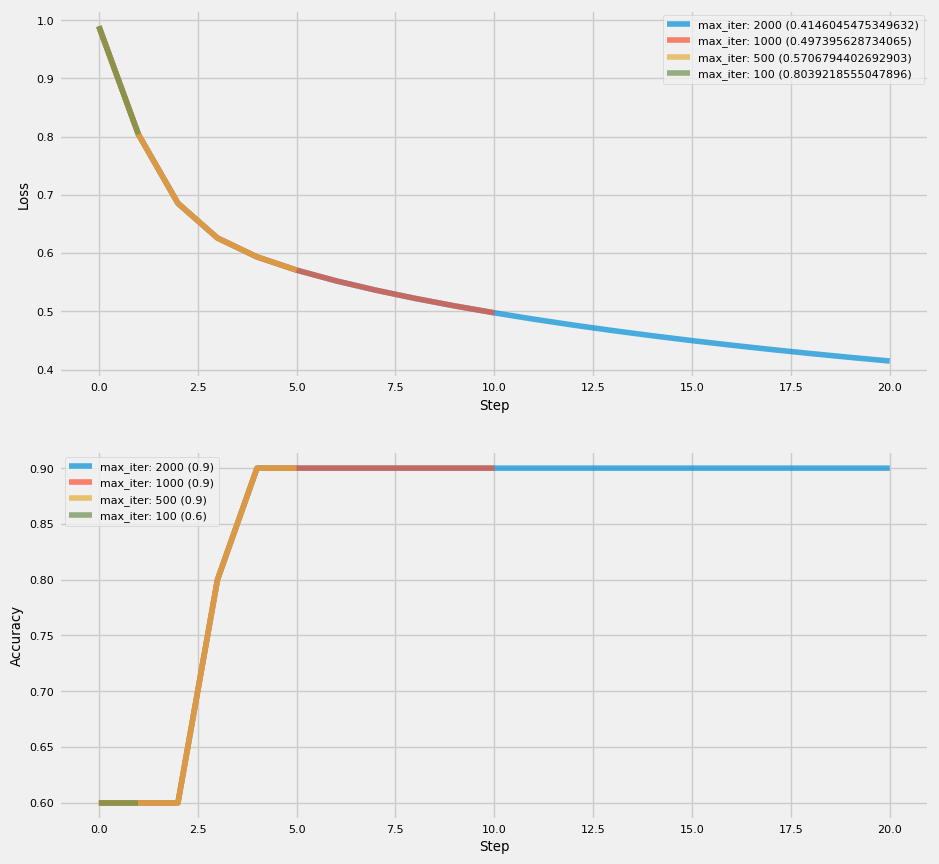

In [11]:
eta = 1e-2
max_iter = 1000
random_state = 64

plt.figure(figsize=(10, 10))
for max_iter in [2000, 1000, 500, 100]:
    lr = LogisticRegression(eta=eta, max_iter=max_iter, random_state=random_state)
    hist = lr.fit(X, y)
    plot_history(hist, label=f"max_iter: {max_iter}")

plt.show()

Увеличение количества итераций позволит подобрать ближе к минимуму ошибки при низкой скорости обучения, но не имеет смысла ставить слишком большое значение.

### Влияние случайности

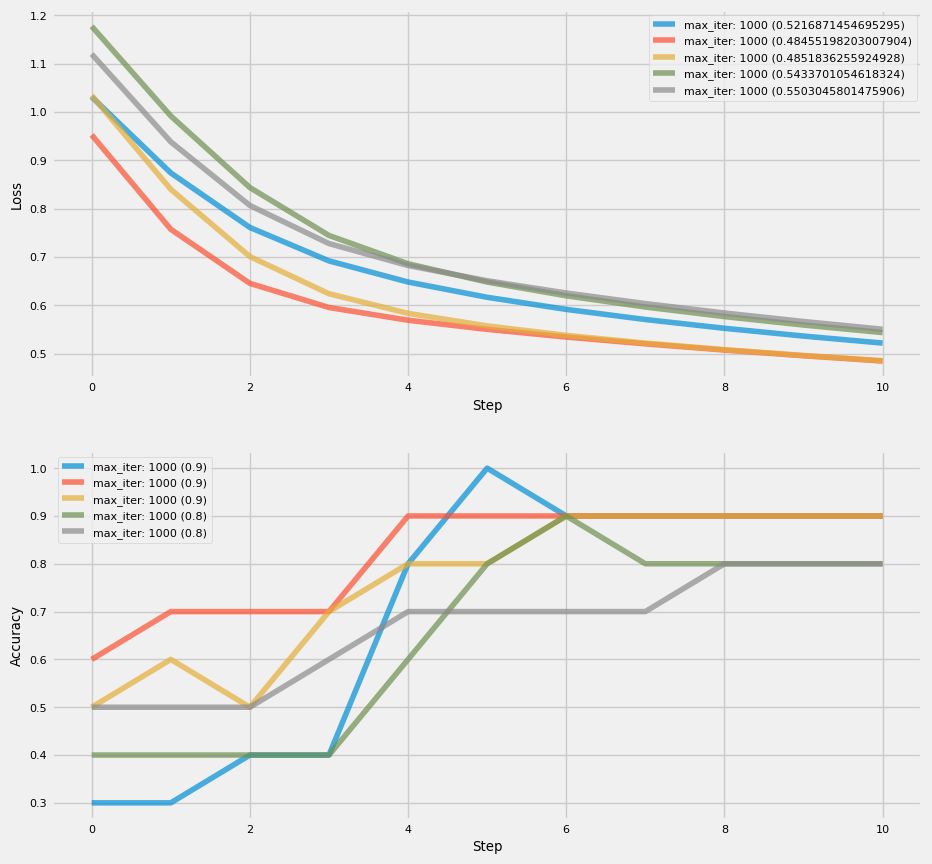

In [12]:
eta = 1e-2
max_iter = 1000
random_state = None

plt.figure(figsize=(10, 10))
for i in range(5):
    lr = LogisticRegression(eta=eta, max_iter=max_iter, random_state=random_state)
    hist = lr.fit(X, y)
    plot_history(hist, label=f"max_iter: {max_iter}")

plt.show()

Если не устанавливать random_state, то модель не будет повторять результат при повторном обучении т.к. начальные веса (точка старта) инициализируется с помощью ```self._w = np.random.rand(size)```. Это хорошо прослеживается на графиках.

### Посмотрим на различные метрики для классификации

In [13]:
eta = 1e-2
max_iter = 1000
random_state = 64

lr = LogisticRegression(eta=eta, max_iter=max_iter, random_state=random_state)
lr.fit(X, y)
y_pred = lr.predict(X)

pd.DataFrame({"real": y, "pred": y_pred}).T

,0,1,2,3,4,5,6,7,8,9
real,0,0,0,1,1,1,1,0,0,0
pred,0,0,0,0,1,1,1,0,0,0


In [14]:
print('accuracy:', accuracy(y, y_pred))
print('precision:', precision(y, y_pred))
print('recall:', recall(y, y_pred))
print('f1_score:', f_score(y, y_pred))
print('confusion_matrix:\n', confusion_matrix(y, y_pred))

accuracy: 0.9
precision: 1.0
recall: 0.75
f1_score: 0.8571428571428571
confusion_matrix:
 [[6 1]
 [0 3]]
